# COMP4030 - Data Science and Machine Learning - Coursework 2

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [167]:
# Utility functions - Ashley Hunt - psyah10
import os

def get_gestures():
      return ['circle', 'come', 'go', 'wave']

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture_dir):
      if not os.path.exists(gesture_dir):
            os.makedirs(gesture_dir)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [168]:
# Data importing functions - Ashley Hunt - psyah10
import pandas as pd

## Simple function to read a csv file and return a dataframe - If scaler is provided, it will scale the data
def get_df(path, scaler=None, trim=True):
      if not path.endswith('.csv'):
            return []
      
      raw_data = pd.read_csv(path)
      raw_data.columns = get_columns()

      df = pd.DataFrame(scaler.fit_transform(raw_data) if scaler else raw_data, columns=raw_data.columns)

      return trim_recording(df) if trim else df

## Function to trim the recording to the first and last significant movement
def trim_recording(df, window_size = 20, threshold = 0.3, padding=90):

      df['rolling_max'] = df['accel_abs'].rolling(window=window_size, min_periods=1).mean()

      start_cut = df[df['rolling_max'] >= threshold].index.min()
      if pd.notna(start_cut):
            cut_index = max(start_cut - padding, 0)
            df = df.loc[cut_index:]
      
      end_cut = df[df['rolling_max'] >= threshold].index.max()
      if pd.notna(end_cut):
            end_cut_index = min(end_cut + padding, len(df) - 1) 
            df = df.loc[:end_cut_index]

      df = df.drop('rolling_max', axis=1)
      return df

## Function to get all the data from the files in the data folder
def get_data_from_files(scaler=None, trim=True, test=False):
      dfs = []
      gestures = get_gestures()
      if test:
            gestures.append('unknown')
      for gesture in gestures:
            folder_path = f'data/{gesture}' if not test else f'data/test/{gesture}/'
            files_in_folder = get_gesture_csvs(folder_path)
            if len(files_in_folder) == 0:
                  continue
            for file_index, file_name in enumerate(files_in_folder):
                  file_path = os.path.join(folder_path, file_name)
                  df = get_df(file_path, scaler, trim)
                  if len(df) == 0:
                        continue

                  df['file_number'] = int(file_index)
                  df['gesture'] = str(gesture)

                  dfs.append(df)
                  
      df = pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]
      df.set_index(['gesture', 'file_number'], inplace=True)
      df.sort_index(inplace=True)
      return df

In [169]:
# Data importing - Ashley Hunt - psyah10
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() ## StandardScaler() or MinMaxScaler()

df = get_data_from_files(scaler, trim=False)
df

time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                   
circle  0            0.000000  0.503507  0.496424  0.148893   0.066289
        0            0.000454  0.502455  0.513937  0.138704   0.088511
        0            0.000908  0.518378  0.519154  0.128645   0.095241
        0            0.001362  0.525563  0.529928  0.126010   0.108404
        0            0.001817  0.539225  0.541297  0.137793   0.120798
...                       ...       ...       ...       ...        ...
wave    4            0.997779  0.451348  0.930679  0.462990   0.001525
        4            0.998334  0.451259  0.931409  0.466659   0.001725
        4            0.998889  0.450396  0.931978  0.469635   0.003205
        4            0.999445  0.448559  0.933373  0.467338   0.003179
        4            1.000000  0.447133  0.932031  0.452452   0.009145

[40096 rows x 5 columns]

In [170]:
# Balance distribution functions - Ashley Hunt - psyah10

def balance_files(df):
      for gesture in df.index.get_level_values('gesture').unique():
            num_files = len(df.loc[(gesture), :].index.unique())
            print(f'{gesture} has {num_files} files (approx. {num_files * 8} gestures)')
            
      average_num_files = df.reset_index().groupby('gesture')['file_number'].nunique().mean()
      print(f'\nAverage number of files per gesture: {average_num_files}')
      
      remove = df.index.get_level_values('file_number').unique()[int(average_num_files)]
      balanced_df = df[df.index.get_level_values('file_number') < remove]
      
      print(f'\nRemoved {len(df) - len(balanced_df)} rows from dataset where file_number >= {remove}')
      return balanced_df

In [171]:
# Balance distribution - Ashley Hunt - psyah10
#df = balance_files(df)
df

time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                   
circle  0            0.000000  0.503507  0.496424  0.148893   0.066289
        0            0.000454  0.502455  0.513937  0.138704   0.088511
        0            0.000908  0.518378  0.519154  0.128645   0.095241
        0            0.001362  0.525563  0.529928  0.126010   0.108404
        0            0.001817  0.539225  0.541297  0.137793   0.120798
...                       ...       ...       ...       ...        ...
wave    4            0.997779  0.451348  0.930679  0.462990   0.001525
        4            0.998334  0.451259  0.931409  0.466659   0.001725
        4            0.998889  0.450396  0.931978  0.469635   0.003205
        4            0.999445  0.448559  0.933373  0.467338   0.003179
        4            1.000000  0.447133  0.932031  0.452452   0.009145

[40096 rows x 5 columns]

In [172]:
# Test data importing - Ashley Hunt - psyah10

test_df = get_data_from_files(scaler, trim=False, test=True)
print(test_df.index.unique(level='gesture'))
test_df

Index(['unknown'], dtype='object', name='gesture')


time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                   
unknown 0            0.000000  0.427672  0.700705  0.426103   0.028583
        0            0.000789  0.427228  0.712001  0.439912   0.050202
        0            0.001578  0.426264  0.701706  0.418560   0.016940
        0            0.002368  0.398847  0.744302  0.413902   0.048063
        0            0.003157  0.410615  0.738453  0.432779   0.051065
...                       ...       ...       ...       ...        ...
        0            0.996844  0.440764  0.714908  0.402939   0.016282
        0            0.997633  0.439390  0.702734  0.394356   0.025445
        0            0.998421  0.436595  0.700726  0.398226   0.018986
        0            0.999211  0.440165  0.708276  0.404871   0.013597
        0            1.000000  0.439163  0.719913  0.409334   0.014046

[1264 rows x 5 columns]

Next we visualise our raw data for exploratory analysis

In [173]:
# Visualising data functions - Ashley Hunt - psyah10
import matplotlib.pyplot as plt

def visualise_df(dataframe, files_per_gesture=2):
    fig, axs = plt.subplots(4, 2, figsize=(16, 12))

    for (gesture, file_number), group in dataframe.loc[(slice(None), range(0,files_per_gesture)), :].groupby(level=['gesture', 'file_number']):

            ax = axs[get_gestures().index(gesture), file_number]

            for col in get_columns()[1:4]:
                ax.plot(range(0, len(group)), group[col], label=col)
                ax.set_title("{gesture} {file_number}".format(gesture=gesture, file_number=file_number))
                ax.set_xlabel('Index')
                ax.set_ylabel('Acceleration')
                ax.legend()
            
    plt.tight_layout()
    plt.show()

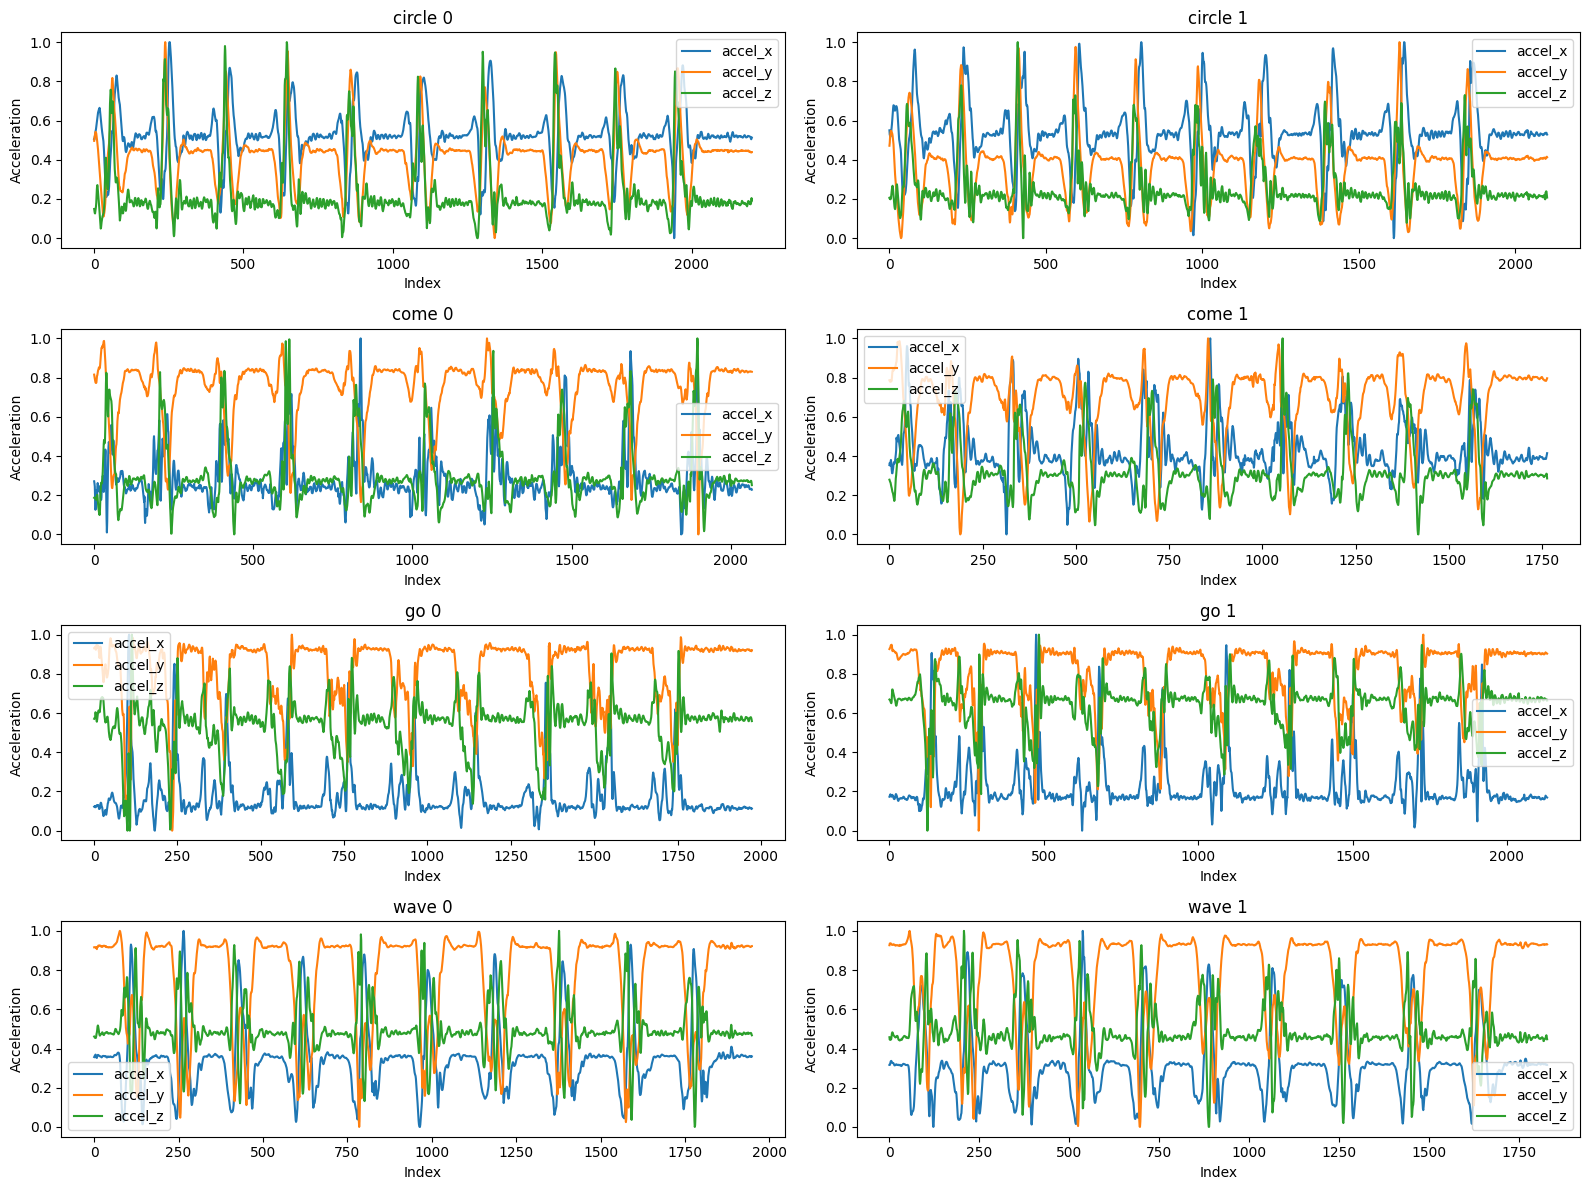

In [174]:
visualise_df(df, files_per_gesture=2)

Next we apply a low-pass filter to reduce noise from the data and make our model more robust

In [175]:
# Low-pass filtering functions - Ashley Hunt - psyah10
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def apply_filter(df, cutoff_freq=2, fs=50, order=5):
    new_df = df.copy()
    for column in get_columns()[1:]:
        new_df[column] = butter_lowpass_filter(new_df[column], cutoff_freq, fs, order)
    return new_df

Now we again visualise our data and using interactive widgets we visually evaluate the performance of different parameter settings for apply the filter.

In [176]:
# Visualising data functions - Ashley Hunt - psyah10
import matplotlib.pyplot as plt

def df_preview(dataframe, files_per_gesture=2):
    
    plt.clf()
    
    fig, axs = plt.subplots(4, files_per_gesture, figsize=(15, files_per_gesture * 4))

    for (gesture, file_number), group in dataframe.loc[(slice(None), range(0, files_per_gesture)), :].groupby(level=['gesture', 'file_number']):

            ax = axs[get_gestures().index(gesture), file_number]

            for col in get_columns()[1:4]:
                ax.plot(range(0, len(group)), group[col], label=col)
                ax.set_title("{gesture} {file_number}".format(gesture=gesture, file_number=file_number))
                ax.set_xlabel('Index')
                ax.set_ylabel('Acceleration')
                ax.legend()
            
    plt.tight_layout()
    plt.show()

In [177]:
# Interactive filter parameter tuning - Ashley Hunt - psyah10
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

cutoff_frequency_slider = widgets.IntSlider(value=2, min=1, max=15, step=1, description='cutoff_frequency')
sampling_rate_slider = widgets.IntSlider(value=70, min=25, max=150, step=1, description='sampling_rate')
filter_order_slider = widgets.IntSlider(value=5, min=1, max=100, step=1, description='filter_order')

def update_signal(cutoff_frequency, sampling_rate, filter_order):
    filtered_df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
    df_preview(filtered_df, files_per_gesture=3)

interactive_plot = widgets.interactive(update_signal, cutoff_frequency=cutoff_frequency_slider, sampling_rate=sampling_rate_slider, filter_order=filter_order_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=2, description='cutoff_frequency', max=15, min=1), IntSlider(value=70, d…

Using the best parameters we then apply these settings to our data

In [181]:
# Filter parameter tuning - Ashley Hunt - psyah10

cutoff_frequency = 2  # Cutoff frequency in Hz - Higher = less smoothing
sampling_rate = 70  # Sampling rate in Hz - Higher = more smoothing
filter_order = 5  # Filter order - Higher = less smoothing

df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
test_df = apply_filter(test_df, cutoff_frequency, sampling_rate, filter_order)

Now we split the data from distinct files into distinct gestures. We do this by using the natural peaks and troughs in absolute acceleration.

In [186]:
# Spltting gestures functions - Ashley Hunt - psyah10
from scipy.signal import find_peaks

def split_file_to_gestures(df, threshold=0.03, padding=10):
      gesture_data = []
      charts = []
      for (gesture, file_number), group in df.groupby(level=['gesture', 'file_number']):
            
            charts.append(gesture) ## Limit to 2 charts per gesture
            
            group.reset_index(drop=True, inplace=True)
            group.drop(['time'], axis=1, inplace=True)
            
            peaks, peak_info = find_peaks(group['accel_abs'], height=0.2, distance=20, width=10, prominence=0.1)
            
            if(len(peaks) < 6 or len(peaks) > 9):
                  print(f"Incorrect peaks in {gesture} {file_number} - {len(peaks)}")
                  plt.plot(group['accel_abs'])
                  plt.plot(peaks, group['accel_abs'][peaks], "x")
                  plt.title(f'{gesture} {file_number}')
                  plt.show()
            
            for peak in peaks:
                  
                  below_target = group.loc[:peak]
                  start_index = below_target[below_target['accel_abs'] < threshold].last_valid_index()
                  if start_index is not None:
                        start_index = max(0, start_index - padding)
                  else:
                        start_index = 0  # Set to 0 if no valid index found
                  
                  above_target = group.loc[peak + 1:]
                  end_index = above_target[above_target['accel_abs'] < threshold].first_valid_index()
                  if end_index is not None:
                        end_index = min(len(group), end_index + padding)
                  else:
                        end_index = len(group)  # Set to the end if no valid index found
                  
                  data = group.loc[start_index:end_index].copy()
                  
                  data['gesture_number'] = len(gesture_data)
                  data['gesture'] = gesture
                  gesture_data.append(data)
      
      gesture_df = pd.concat(gesture_data, ignore_index=True)
      gesture_df.set_index(['gesture', 'gesture_number'], inplace=True)
      return gesture_df

Incorrect peaks in circle 0 - 10


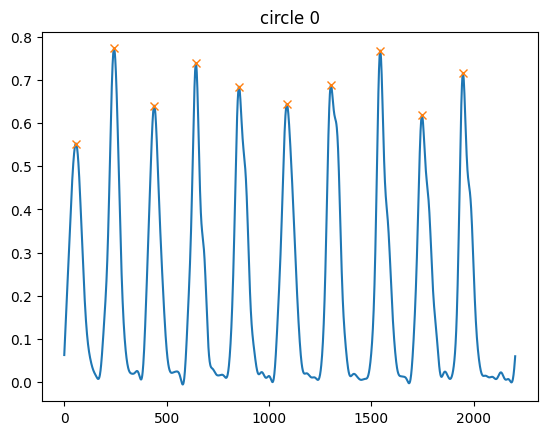

Incorrect peaks in circle 1 - 10


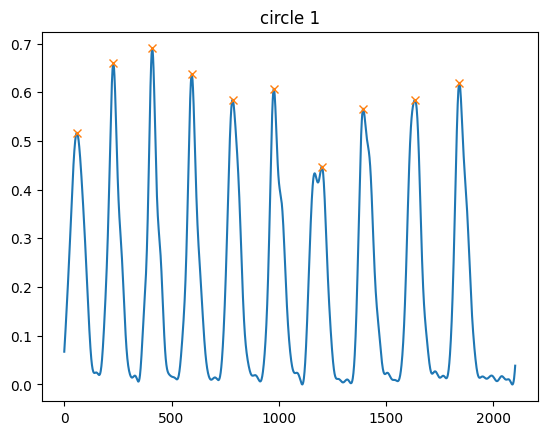

Incorrect peaks in circle 2 - 10


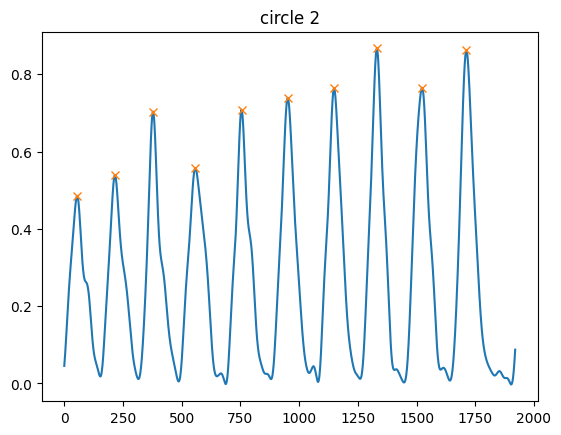

Incorrect peaks in circle 3 - 10


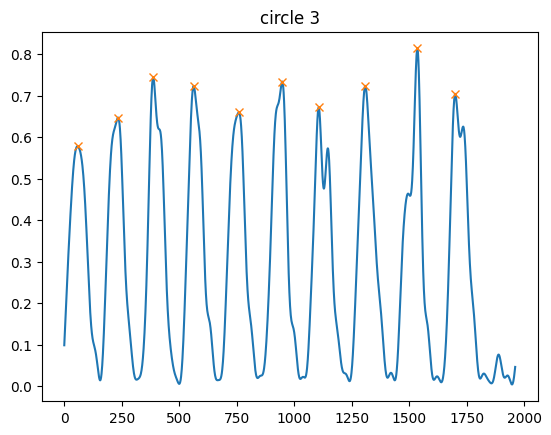

Incorrect peaks in circle 4 - 10


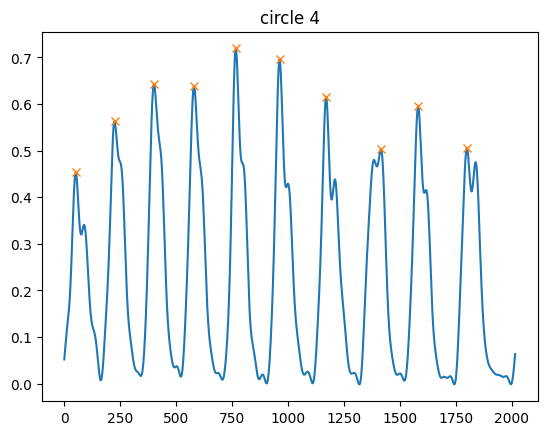

Incorrect peaks in come 0 - 10


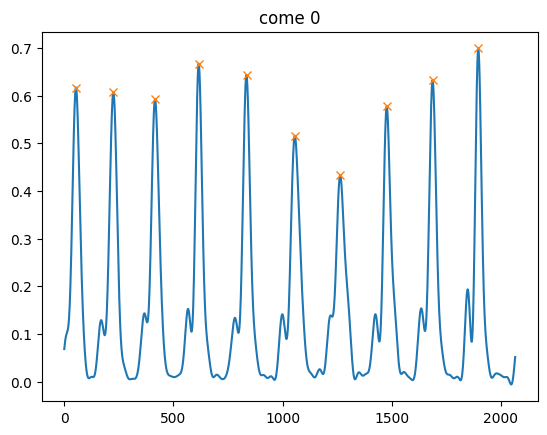

Incorrect peaks in come 1 - 10


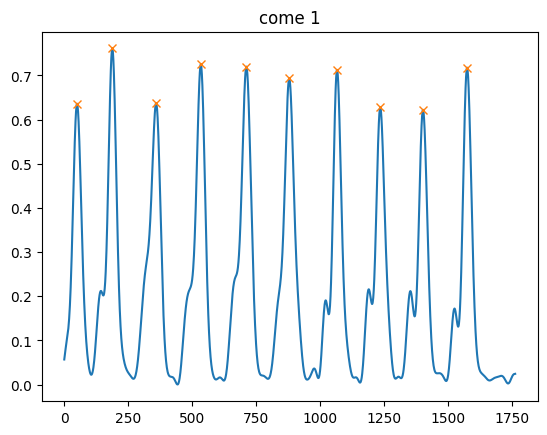

Incorrect peaks in come 2 - 10


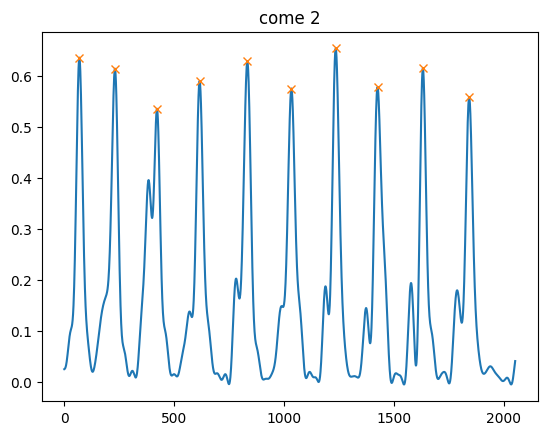

Incorrect peaks in come 3 - 12


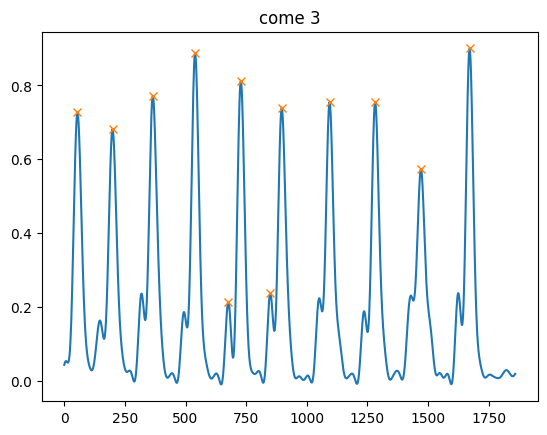

Incorrect peaks in come 4 - 10


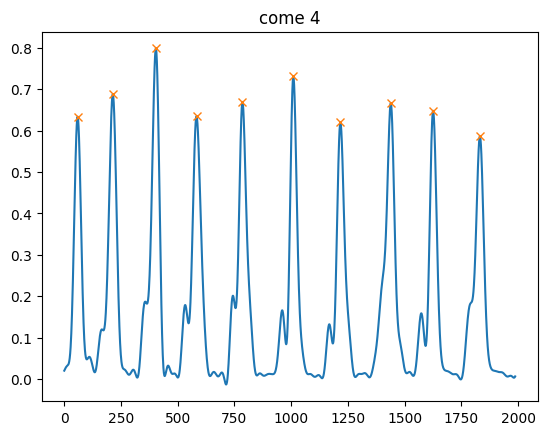

Incorrect peaks in go 0 - 12


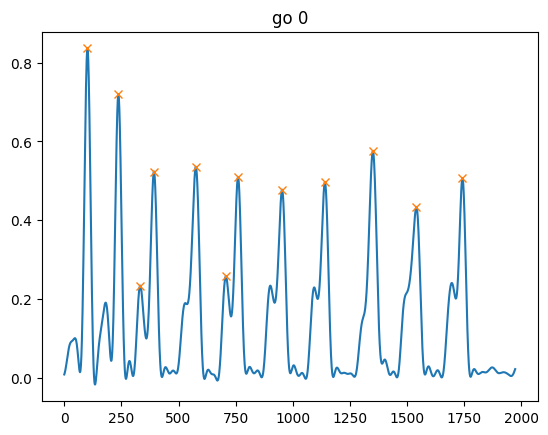

Incorrect peaks in go 1 - 12


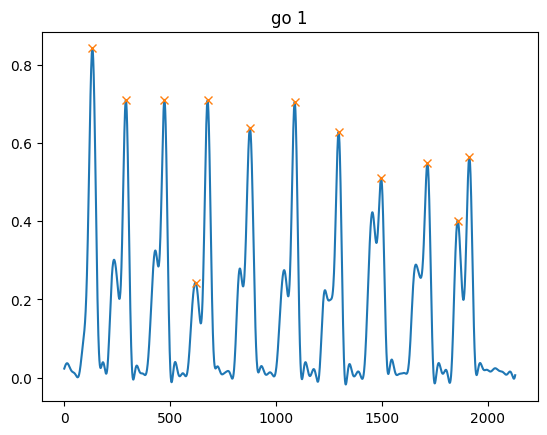

Incorrect peaks in go 2 - 11


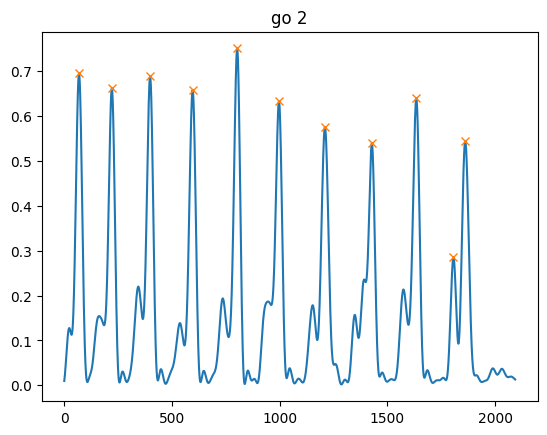

Incorrect peaks in go 3 - 10


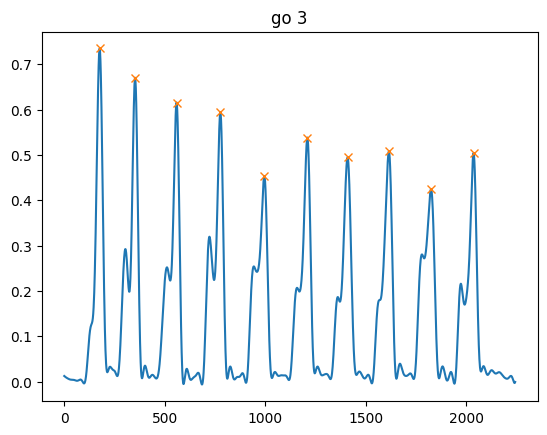

Incorrect peaks in go 4 - 15


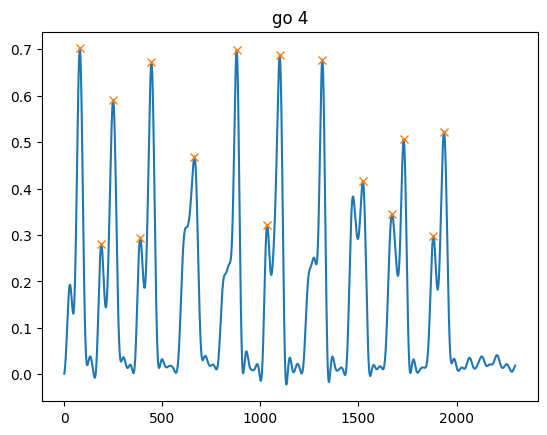

Incorrect peaks in wave 0 - 10


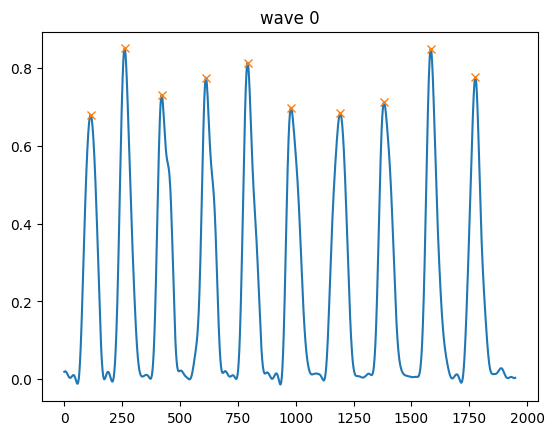

Incorrect peaks in wave 1 - 10


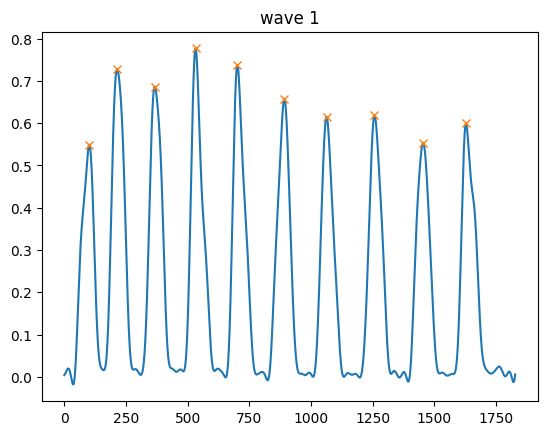

Incorrect peaks in wave 2 - 10


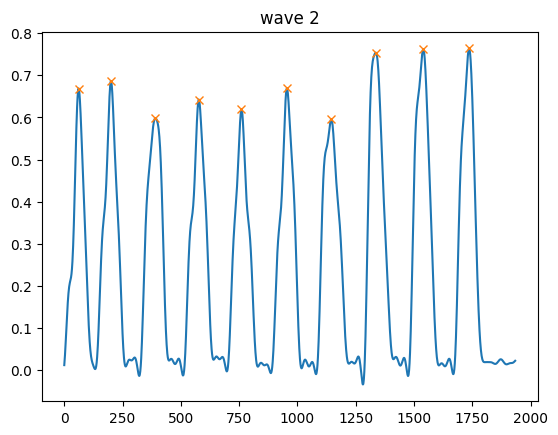

Incorrect peaks in wave 3 - 10


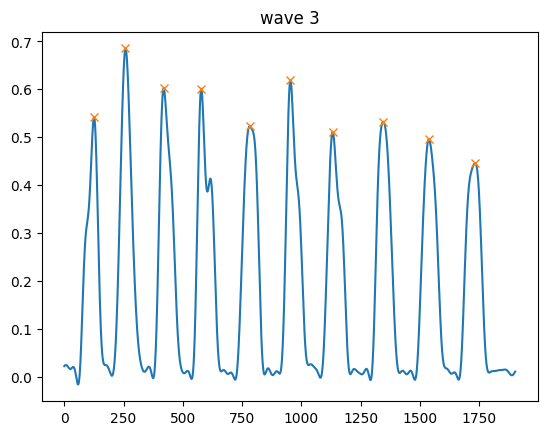

Incorrect peaks in wave 4 - 10


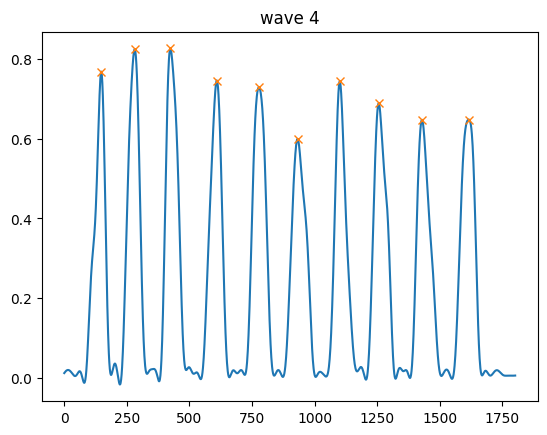

accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
circle  0               0.496842  0.514521  0.159036   0.063076
        0               0.510821  0.512043  0.162849   0.073929
        0               0.524918  0.509381  0.166492   0.084744
        0               0.539000  0.506378  0.169862   0.095506
        0               0.552927  0.502874  0.172854   0.106206
...                          ...       ...       ...        ...
wave    211             0.457788  0.953683  0.464386   0.006164
        211             0.457249  0.945610  0.466207   0.005952
        211             0.456228  0.937933  0.467643   0.006242
        211             0.454830  0.930810  0.468693   0.006929
        211             0.453156  0.924371  0.469364   0.007909

[30480 rows x 4 columns]

In [187]:
# Spltting gestures - Ashley Hunt - psyah10

gesture_df = split_file_to_gestures(df, threshold=0.03, padding=10)
gesture_df

In [188]:
# Spltting gestures on test data - Ashley Hunt - psyah10

test_gesture_df = split_file_to_gestures(test_df, threshold=0.03, padding=10)
test_gesture_df

accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
unknown 0               0.390239  0.695381  0.407136   0.009256
        0               0.391430  0.690344  0.405192   0.008702
        0               0.393450  0.685452  0.403076   0.008525
        0               0.396333  0.680859  0.400822   0.008783
        0               0.400095  0.676723  0.398470   0.009535
...                          ...       ...       ...        ...
        7               0.421138  0.710805  0.406003   0.003037
        7               0.414283  0.707150  0.407119   0.001605
        7               0.408543  0.703949  0.408074   0.000706
        7               0.403961  0.701246  0.408860   0.000288
        7               0.400545  0.699063  0.409471   0.000297

[872 rows x 4 columns]

Now we visualise these gestures.

In [189]:
# Visualising data functions - Ashley Hunt - psyah10

def visualise_gestures(dataframe, n):
      charts = []
      plt.figure(figsize=(n * 4, 10))
      for (gesture, gesture_number), group in dataframe.groupby(level=['gesture', 'gesture_number']):
            
            charts.append(gesture) ## Limit charts per gesture
            if(charts.count(gesture) > n):
                  continue
            
            gesture_i = len(pd.Series(charts).unique()) - 1
            plt.subplot(4, n, (n * gesture_i ) + charts.count(gesture) )
            
            group.reset_index(drop=True, inplace=True)
            for col in get_columns()[1:4]:
                  plt.plot(range(len(group)), group[col], label=col)
                  plt.title("{gesture} {gesture_number}".format(gesture=gesture, gesture_number=gesture_number))
                  plt.ylim(0, 1)
      plt.subplots_adjust(hspace=0.4)
      plt.show()

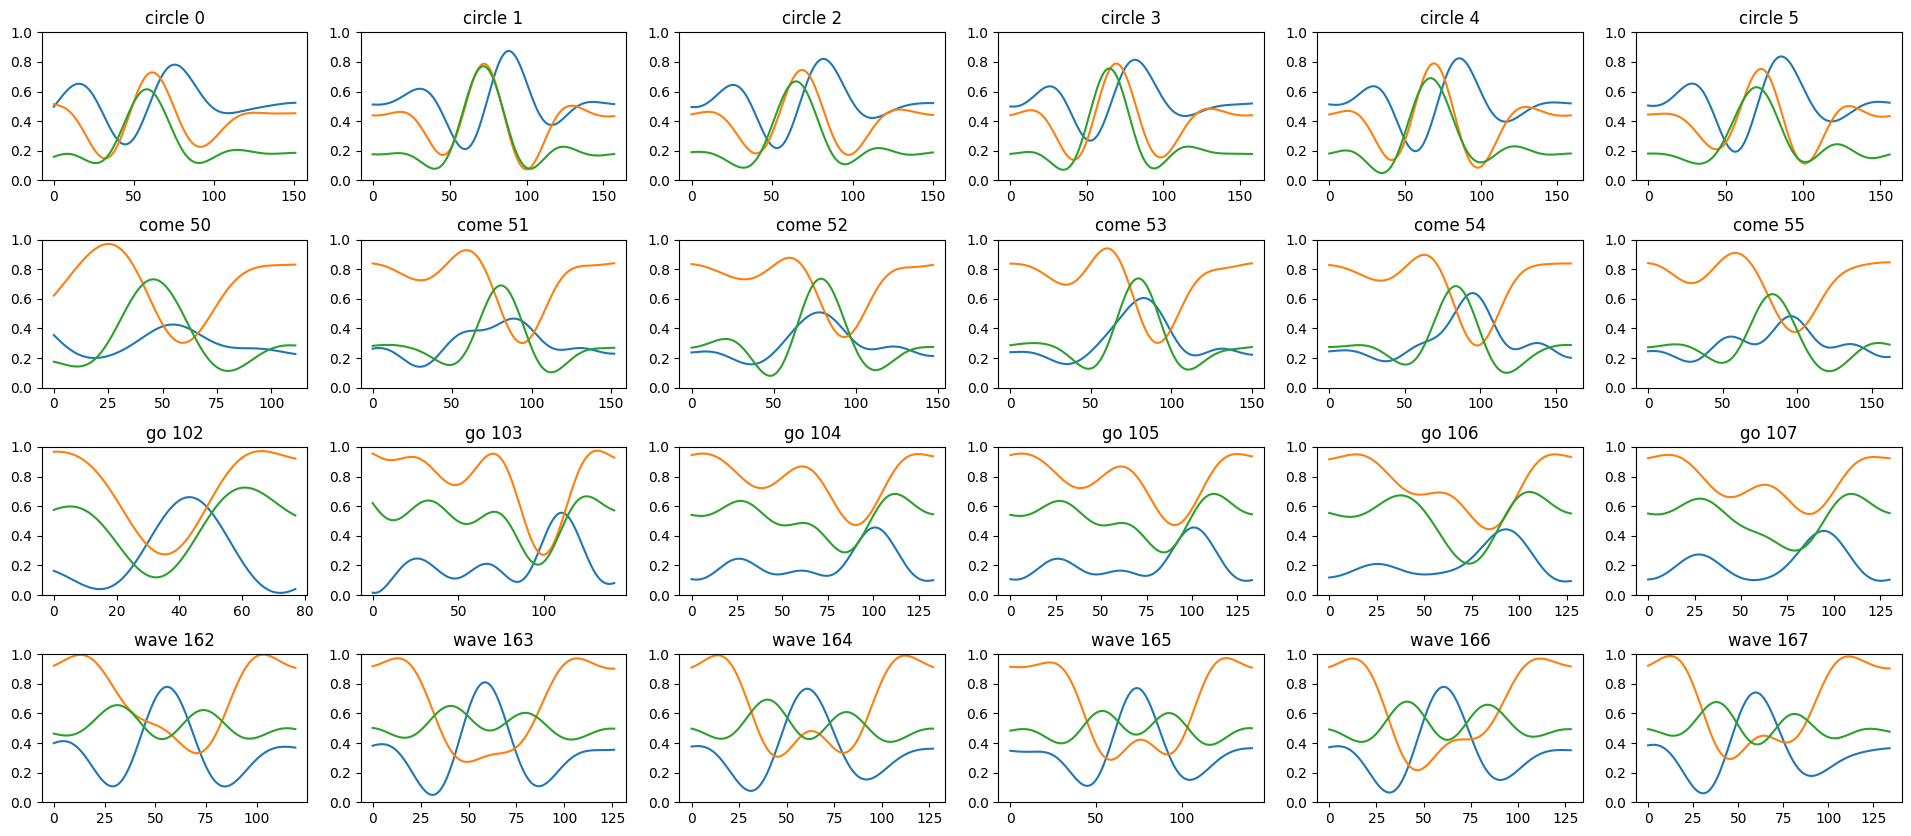

In [190]:
# Visualising data - Ashley Hunt - psyah10

visualise_gestures(gesture_df, 6)

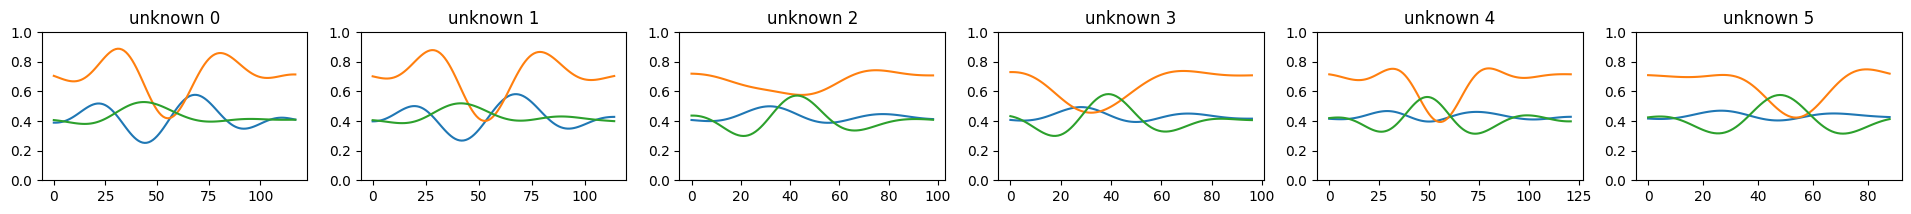

In [ ]:
# Visualising data - Ashley Hunt - psyah10

visualise_gestures(test_gesture_df, 6)

If, due to slicing errors, there are duplicate gestures we will remove them

In [192]:
# Removing duplicate functions - Ashley Hunt - psyah10

def remove_duplicate_gestures(dataframe):
      data = dataframe.copy()
      
      data_columns = get_columns()[1:]
      group_columns = ['gesture', 'gesture_number']

      grouped = data.groupby(group_columns)

      group_representations = {}
      duplicates_found = False
      for name, group in grouped:
            group_tuple = tuple(group.sort_values(by=data_columns)[data_columns].itertuples(index=False, name=None))
            
            if group_tuple in group_representations:
                  duplicates_found = True
                  data = data.drop(name)
                  print("Removing identical gestures", name, "and", group_representations[group_tuple])
            group_representations[group_tuple] = name
            
      if not duplicates_found:
            print("No duplicate gestures found")
      return data

In [193]:
# Removing duplicate slices - Ashley Hunt - psyah10

gesture_df = remove_duplicate_gestures(gesture_df)
test_gesture_df = remove_duplicate_gestures(test_gesture_df)

Removing identical gestures ('come', 85) and ('come', 84)
Removing identical gestures ('come', 87) and ('come', 86)
Removing identical gestures ('go', 105) and ('go', 104)
Removing identical gestures ('go', 108) and ('go', 107)
Removing identical gestures ('go', 118) and ('go', 117)
Removing identical gestures ('go', 125) and ('go', 124)
Removing identical gestures ('go', 136) and ('go', 135)
Removing identical gestures ('go', 149) and ('go', 148)
Removing identical gestures ('go', 151) and ('go', 150)
Removing identical gestures ('go', 155) and ('go', 154)
Removing identical gestures ('go', 159) and ('go', 158)
Removing identical gestures ('go', 161) and ('go', 160)
No duplicate gestures found


Next we apply a Fourier transformation on the data and filter out the frequencies in the data that are not adding useful information. This is achieved using trial and error through visualisation of the wave before and after transformation.

In [194]:
# Fourier Transformation functions - Ashley Hunt - psyah10
import numpy as np

def fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data), 1/sample_rate)

    mask = (freqs > cutoff_freq_low) & (freqs < cutoff_freq_high)
    fft_data[~mask] = 0

    filtered_signal = np.fft.ifft(fft_data).real
    return filtered_signal

def apply_fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    new_df = data.copy()
    for column in get_columns()[1:4]:
        new_df[column] = fft_filter(new_df[column], sample_rate, cutoff_freq_low, cutoff_freq_high)
    return new_df

def visually_compare_fft(original_df, filtered_df, visualise_n=3):

    for name, group in original_df.groupby(level='gesture'):
        
        first_n_gestures = group.index.get_level_values('gesture_number').unique()[:visualise_n]
        data = group[group.index.get_level_values('gesture_number').isin(first_n_gestures)]
        
        for n, g_data in data.groupby(level='gesture_number'):

            plt.figure(figsize=(10, 2))

            plt.subplot(1, 2, 1)
            for col in get_columns()[1:4]:
                plt.plot(range(len(g_data)), g_data[col], label=f'Original {col}', alpha=0.5)
            plt.title(f"{name}, {n}")

            plt.subplot(1, 2, 2)
            filtered_data = filtered_df.loc[(name, n)]
            for col in get_columns()[1:4]:
                plt.plot(range(len(filtered_data)), filtered_data[col], label=f'Filtered {col}', linestyle='--')
            plt.title(f'Filtered {name}')

            plt.tight_layout()
            plt.show()

In [195]:
# Fourier Transformation - Ashley Hunt - psyah10
 
sample_rate = 1000  # Sampling rate (Hz)
cutoff_low = 2  # Low cutoff frequency (Hz)
cutoff_high = 25  # High cutoff frequency (Hz) 

fft_filtered_gestures_df = apply_fft_filter(gesture_df, sample_rate, cutoff_low, cutoff_high)
fft_test_filtered_gestures_df = apply_fft_filter(test_gesture_df, sample_rate, cutoff_low, cutoff_high)

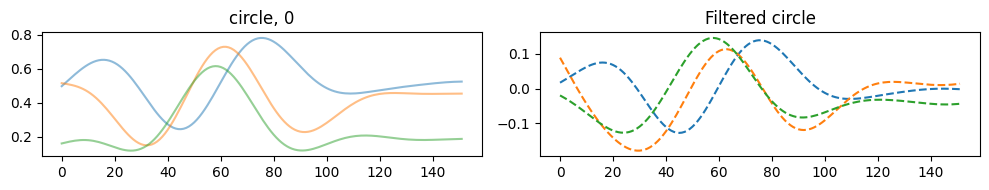

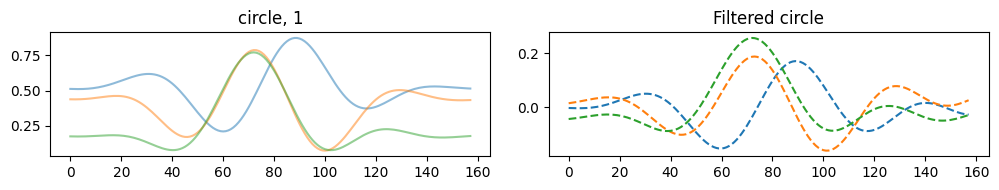

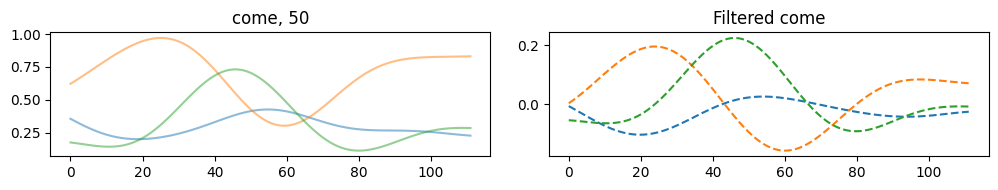

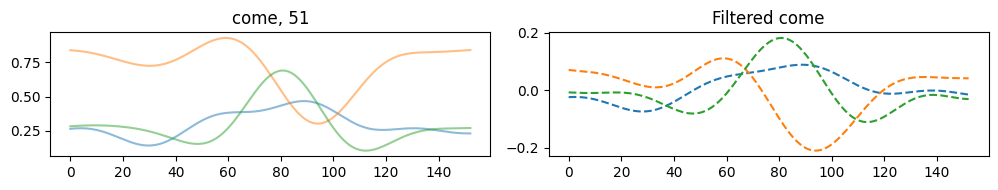

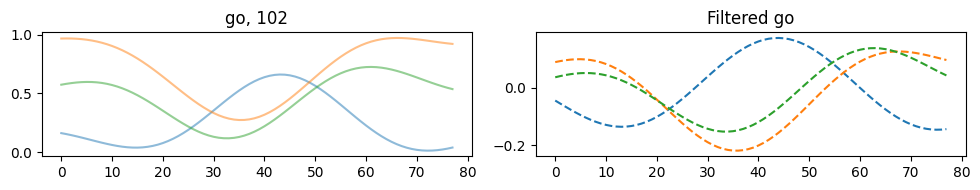

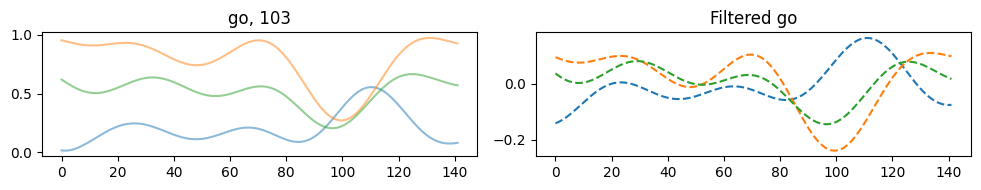

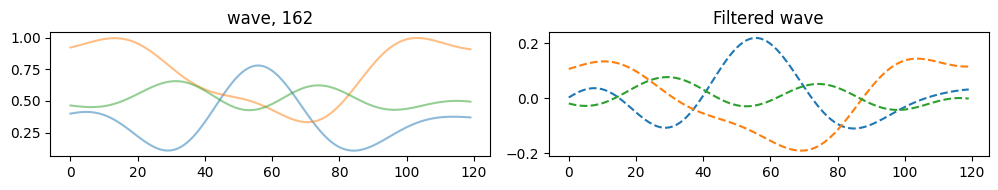

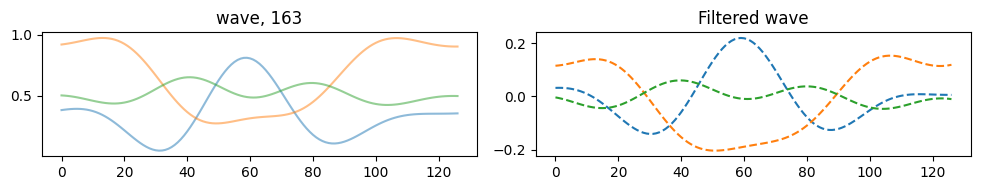

In [196]:
# Visualise the FFT filter alongside the original data
visually_compare_fft(gesture_df, fft_filtered_gestures_df, 2)

Next we can begin to extract our features for the models. These functions split the data into a fixed number of segments with some overlap and then take some key statistical values from these slices.

In [198]:
# Feature extraction functions - Ashley Hunt - psyah10

def extract_segments(df, num_segments, overlap_fraction):
    total_rows = len(df)
    segment_size = total_rows // num_segments
    overlap_size = int(segment_size * overlap_fraction)
    
    segments = []
    
    for i in range(num_segments):
        start_idx = i * segment_size
        if i > 0:
            start_idx -= overlap_size
        
        if i == num_segments - 1:
            end_idx = total_rows
        else:
            end_idx = start_idx + segment_size + overlap_size

        segments.append(df.iloc[start_idx:end_idx])
    
    return segments

def extract_features_from_df(df, feature_functions, num_segments = 4, overlap_fraction = 0.1):
      results = []
      
      for (gesture, gesture_number), group in df.groupby(level=['gesture', 'gesture_number']):
            
            group.reset_index(drop=True, inplace=True)

            result_dict = {}
            segments = extract_segments(group, num_segments, overlap_fraction)
            result_dict['gesture'] = gesture
            for n, segment in enumerate(segments):
                  for col in get_columns()[1:4]:
                        for f in feature_functions:
                              result_dict[f'{col}_{f}_{n+1}'] = segment[col].agg(f)

            results.append(result_dict)

      return pd.DataFrame(results)

In [199]:
# Feature extraction - Ashley Hunt - psyah10

# Function options 'mean', 'min', 'max', 'median', 'std', 'skew', 'kurtosis', 'quantile'
feature_functions = ['mean', 'min', 'max', 'std', 'kurtosis', 'skew'] 
num_segments = 8
overlap_fraction = 0.3

extracted_features = extract_features_from_df(fft_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)
extracted_features


extracted_test_features = extract_features_from_df(fft_test_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)

In [200]:
# Visualisting Feature extraction functions - Ashley Hunt - psyah10

def show_trends(dataframe):
      for f in feature_functions:
            plt.figure(figsize=(15, 3))
            for col in get_columns()[1:4]:
                  plt.subplot(1, 3, get_columns().index(col))
                  plt.title(col)
                  for g in get_gestures():
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append( dataframe.loc[dataframe["gesture"] == g][f'{col}_{f}_{s}'].mean())
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=g)
                        plt.xlabel('Segment')
                        plt.ylabel(f)
                        plt.legend()
                        plt.xticks(range(1, num_segments + 1))
            plt.suptitle(f"{f} by segment")
            plt.tight_layout()
            plt.show()

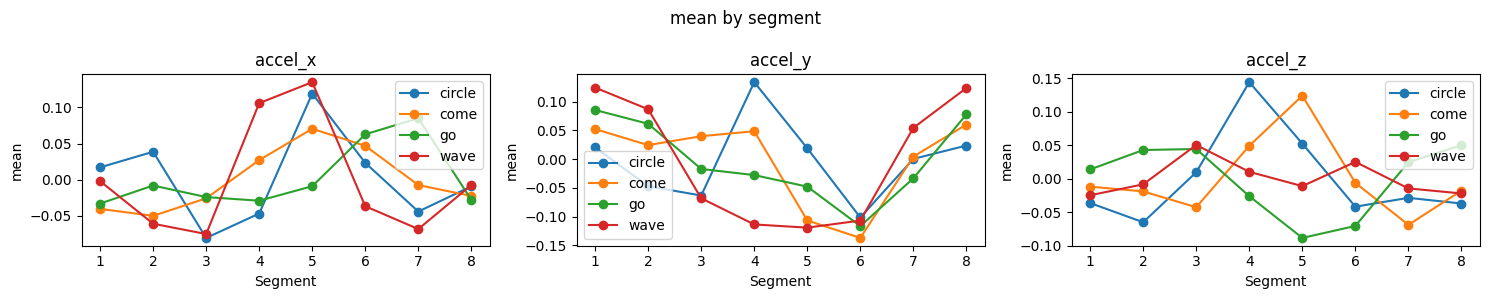

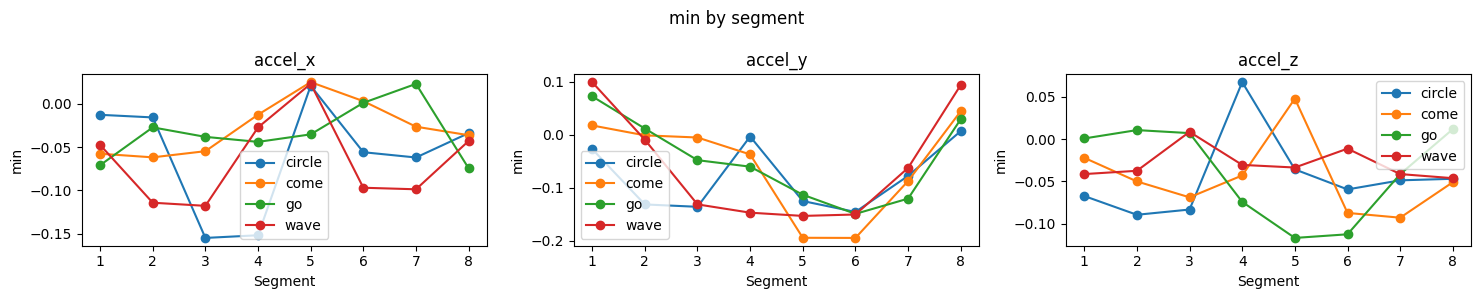

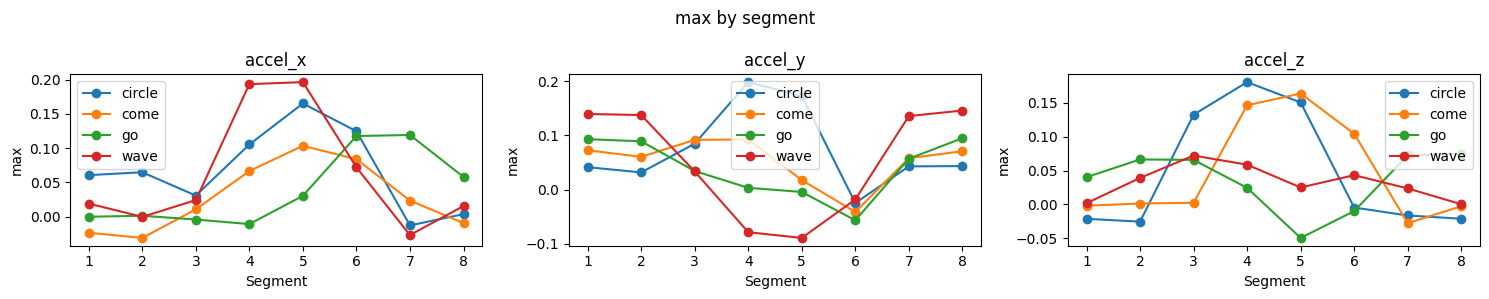

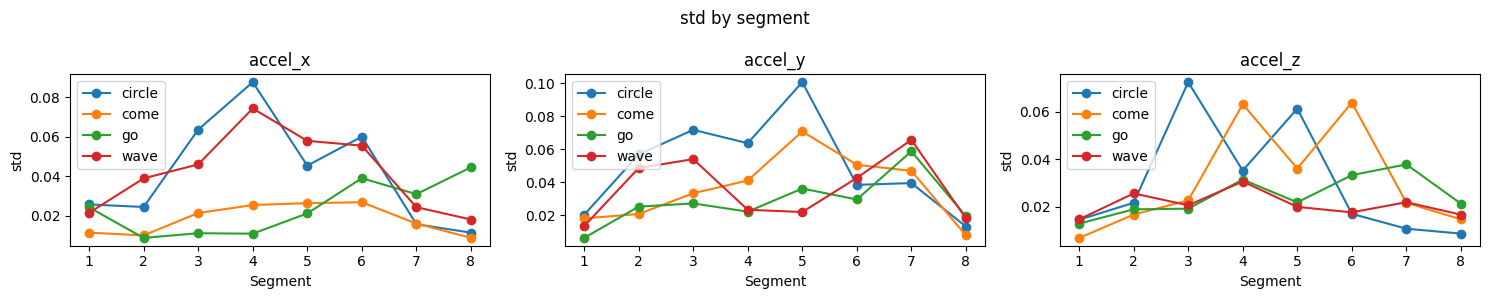

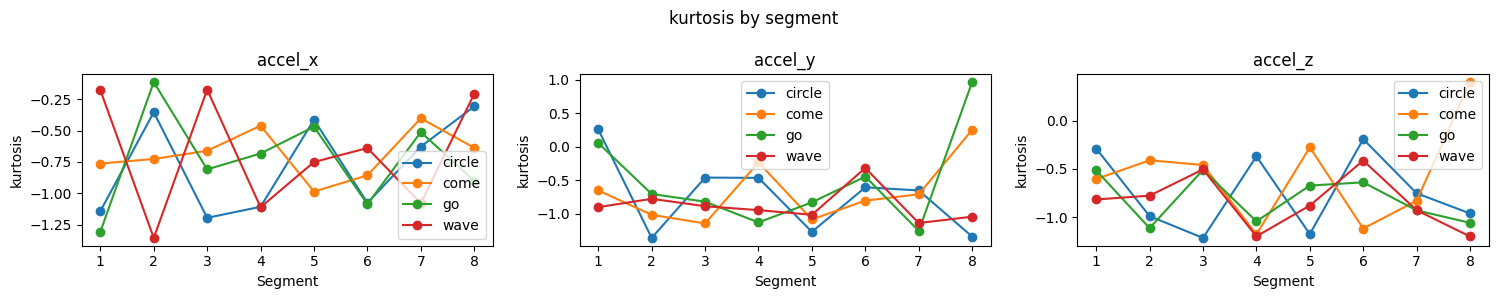

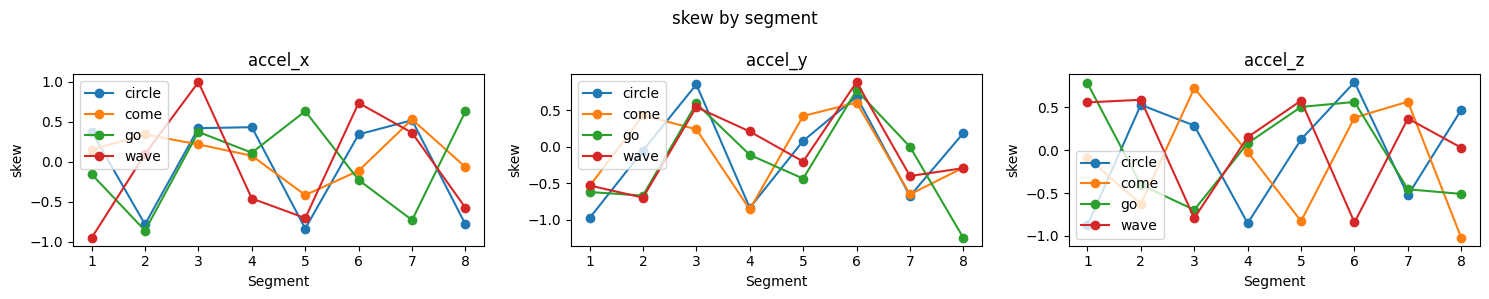

In [201]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

show_trends(extracted_features)

In [ ]:
# Visualisting individual feature extraction for selection - Ashley Hunt - psyah10

def show_trend(dataframe, function, charts_per_gesture=4):
      
      for g in get_gestures():
            if len(dataframe.loc[dataframe["gesture"] == g]) == 0:
                  continue
            plt.figure(figsize=(charts_per_gesture * 4, 3))
            plt.title(f"{charts_per_gesture} {g}'s {function}")
            for graphs in range(0, charts_per_gesture):
                  plt.subplot(1, charts_per_gesture, graphs + 1)
                  
                  data = dataframe.loc[dataframe["gesture"] == g].iloc[graphs]
                  for col in get_columns()[1:4]:
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append(data[f'{col}_{function}_{s}'])
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=col)
                  plt.legend()
                  plt.xticks(range(1, num_segments + 1))
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

# for f in feature_functions:
#       show_trend(extracted_features, f, 3)

In [202]:
# Balance data functions - Ashley Hunt - psyah10

def rebalance_data(dataframe):
      # Find out the minimum number of gestures in a category
      min_gestures = dataframe['gesture'].value_counts().min()

      # Take only the top x gestures
      return dataframe.groupby('gesture').head(min_gestures)


In [203]:
# Re-balance data - Ashley Hunt - psyah10

extracted_features = rebalance_data(extracted_features)
extracted_features

gesture  accel_x_mean_1  accel_x_min_1  accel_x_max_1  accel_x_std_1  \
0    circle        0.055270       0.016830       0.074743       0.018312   
1    circle        0.008300      -0.003061       0.035997       0.012854   
2    circle        0.014334      -0.027045       0.063671       0.032609   
3    circle        0.013791      -0.024310       0.062812       0.031817   
4    circle        0.013188      -0.016523       0.059733       0.027290   
..      ...             ...            ...            ...            ...   
195    wave       -0.010625      -0.034454       0.012675       0.014231   
196    wave        0.002112      -0.037164       0.015584       0.016345   
197    wave       -0.001701      -0.041832       0.012738       0.017538   
198    wave        0.001295      -0.044117       0.022648       0.021752   
199    wave        0.002277      -0.023726       0.011367       0.009999   

     accel_x_kurtosis_1  accel_x_skew_1  accel_y_mean_1  accel_y_min_1  \
0             -0.585290       -0.793627       -0.051908      -0.160100   
1             -0.480437        0.930172        0.028733       0.015233   
2             -1.528011        0.164403        0.037625      -0.007177   
3             -1.525895        0.235257        0.027767      -0.004678   
4             -1.363217        0.428786        0.025724      -0.025002   
..                  ...             ...             ...            ...   
195           -1.078252        0.004529        0.104598       0.098150   
196            0.646853       -1.320540        0.121767       0.094006   
197            0.144520       -1.159256        0.116074       0.092242   
198           -0.585014       -0.821981        0.106598       0.087856   
199            1.527520       -1.451271        0.135802       0.105378   

     accel_y_max_1  ...  accel_y_max_8  accel_y_std_8  accel_y_kurtosis_8  \
0         0.088623  ...       0.018767       0.002868           -0.800365   
1         0.037030  ...       0.078269       0.026164           -1.249320   
2         0.055182  ...       0.050874       0.022425           -1.741179   
3         0.047073  ...       0.048993       0.018659           -1.655449   
4         0.045541  ...       0.052829       0.012955           -0.615992   
..             ...  ...            ...            ...                 ...   
195       0.111108  ...       0.140518       0.017338           -1.469048   
196       0.139916  ...       0.122083       0.013438           -1.690303   
197       0.129676  ...       0.111772       0.007190            0.916154   
198       0.115482  ...       0.139259       0.014831           -1.773043   
199       0.154511  ...       0.214797       0.033399           -0.237041   

     accel_y_skew_8  accel_z_mean_8  accel_z_min_8  accel_z_max_8  \
0          0.691816       -0.041956      -0.045724      -0.034789   
1          0.582105       -0.030720      -0.048763       0.003343   
2         -0.058644       -0.041147      -0.060934      -0.008863   
3          0.268361       -0.040412      -0.052058      -0.019418   
4          0.893948       -0.035909      -0.042126      -0.026424   
..              ...             ...            ...            ...   
195       -0.239418       -0.023407      -0.051978       0.011146   
196       -0.103696       -0.029388      -0.052223      -0.006704   
197       -0.923020       -0.033933      -0.050055      -0.009026   
198        0.011777       -0.000298      -0.020923       0.012313   
199       -0.841143        0.020529      -0.015724       0.052195   

     accel_z_std_8  accel_z_kurtosis_8  accel_z_skew_8  
0         0.003652           -0.929266        0.707288  
1         0.016874           -0.704018        0.773331  
2         0.018176           -1.152675        0.598418  
3         0.009840           -0.905130        0.524028  
4         0.005106           -1.240267        0.371845  
..             ...                 ...             ...  
195       0.024365           -1.659105        0.2

In [204]:
# Principle Component Analysis & Extraction functions - Ashley Hunt - psyah10

from sklearn.decomposition import PCA
import seaborn as sns

def extract_principle_components(dataframe, components=2):
      
      data = dataframe.reset_index()
      gestures = data['gesture']
      data = data.loc[:, (data.columns != 'gesture') & (data.columns != 'index')]

      pca = PCA(n_components=components)
      principal_components = pca.fit_transform(data)
      cols = [f'principal component {i}' for i in range(1, components + 1)]
      principle_df = pd.DataFrame(data = principal_components, columns = cols)
      principle_df['gesture'] = gestures

      return principle_df

def visualise_principle_components(dataframe):
      cols = len(dataframe.columns) - 1
      plt.figure(figsize=(cols * 3, cols * 3))
      sns.pairplot(principle_features, hue="gesture", palette="deep")
      plt.show()

In [205]:
# Principle Component Analysis & Extraction - Ashley Hunt - psyah10
principle_features = extract_principle_components(extracted_features, components=5)
test_principle_features = extract_principle_components(extracted_test_features, components=5)
principle_features

principal component 1  principal component 2  principal component 3  \
0                -1.873592              -0.810975              -0.854437   
1                -1.786097               1.140062               0.860904   
2                -2.326302               0.904486               3.006102   
3                -2.362721               0.789905               1.310468   
4                -2.043582               1.381422               1.359174   
..                     ...                    ...                    ...   
195              -0.978878              -3.180864              -0.552914   
196              -1.080712              -4.135860              -1.083410   
197               0.812844              -2.987481              -0.522746   
198              -1.206074              -2.504974              -0.279014   
199               0.372583              -3.028912              -0.553223   

     principal component 4  principal component 5 gesture  
0                 0.796041               0.394710  circle  
1                -1.393838               0.031179  circle  
2                -0.201858               0.554425  circle  
3                -0.512475               0.532063  circle  
4                 0.828971              -0.222587  circle  
..                     ...                    ...     ...  
195              -1.298106               1.592766    wave  
196              -0.180506               0.804655    wave  
197              -0.071856               1.260951    wave  
198               1.614975              -1.026156    wave  
199              -0.597871               2.114849    wave  

[200 rows x 6 columns]

<Figure size 1500x1500 with 0 Axes>

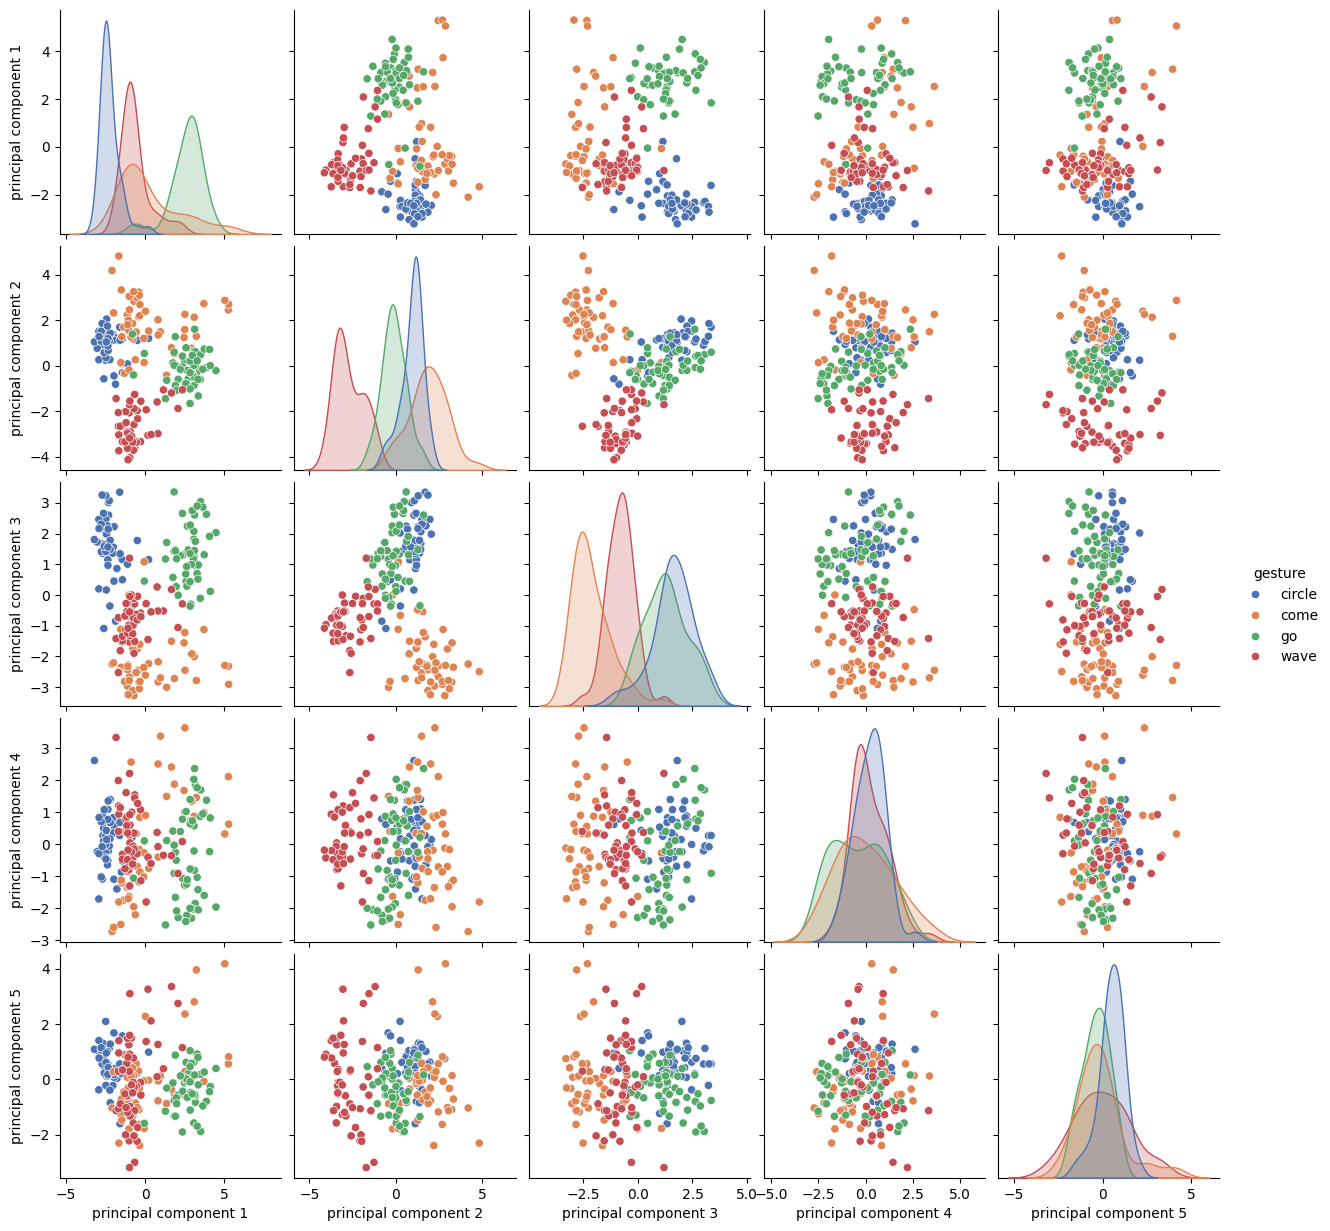

In [206]:
visualise_principle_components(principle_features)

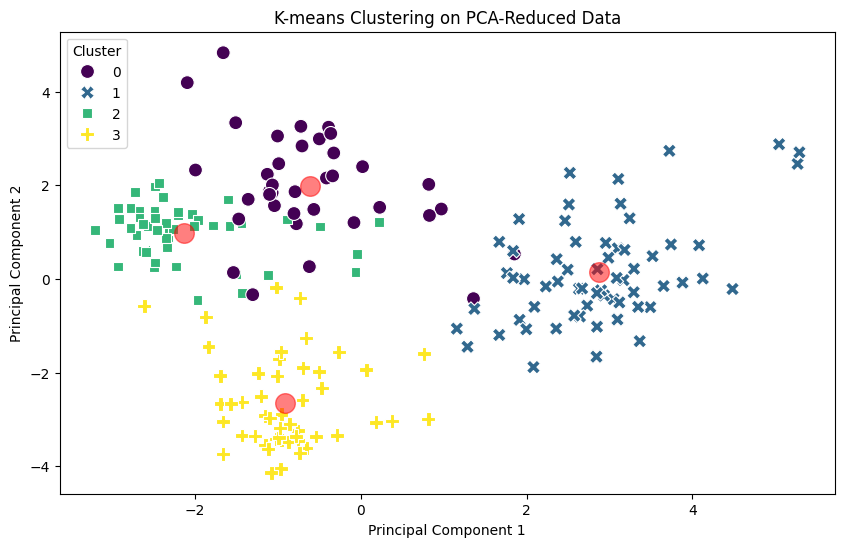

Silhouette Score: 0.4094989441308038


In [207]:
# K-means clustering analysis - Ashley Hunt - psyah10

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_clustering(dataframe, k=3):
      data = dataframe.reset_index().copy()
      data = data.loc[:, (data.columns != 'gesture') & (data.columns != 'index')]

      kmeans = KMeans(n_clusters=k, random_state=42)

      kmeans.fit(data)
      data['Cluster'] = kmeans.fit_predict(data)

      centers = kmeans.cluster_centers_
      labels = kmeans.labels_

      plt.figure(figsize=(10, 6))
      sns.scatterplot(x='principal component 1', y='principal component 2', hue='Cluster', data=data, palette='viridis', style='Cluster', s=100)
      plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
      plt.title('K-means Clustering on PCA-Reduced Data')
      plt.xlabel('Principal Component 1')
      plt.ylabel('Principal Component 2')
      plt.legend(title='Cluster')
      plt.show()
      
      score = silhouette_score(data.drop('Cluster', axis=1), data['Cluster'])
      print('Silhouette Score:', score)

kmeans_clustering(principle_features, k=4)

In [208]:
# Label encoding - Ashley Hunt - psyah10
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_labels(labels):
    return label_encoder.fit_transform(labels)

def decode_labels(encoded_labels):
    return label_encoder.inverse_transform(encoded_labels)

In [209]:
# Data splitting - Ashley Hunt - psyah10
from sklearn.model_selection import train_test_split

PRINCIPLE = True

if PRINCIPLE:
      X = principle_features.loc[:, principle_features.columns != 'gesture']
      Y = encode_labels(principle_features['gesture'])
      UNSEEN_FEATURES = test_principle_features.loc[:, test_principle_features.columns != 'gesture']
else:
      X = extracted_features.loc[:, extracted_features.columns != 'gesture']
      Y = encode_labels(extracted_features['gesture'])
      UNSEEN_FEATURES = extracted_test_features.loc[:, extracted_test_features.columns != 'gesture']

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.3, random_state=42)

In [211]:
# Shreeya 
#KNN 

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize the scaler and the KNN classifier
scaler = StandardScaler()
knn = KNeighborsClassifier()

# Create a pipeline that first scales the data then applies KNN
pipeline = Pipeline([('scaler', scaler), ('knn', knn)])

# Parameters of the KNN classifier to tune
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Example range; can be expanded based on computational resources
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(train_features, train_labels)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_pred = best_model.predict(test_features)
print("Test set accuracy: ", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))
print(confusion_matrix(test_labels, test_pred))






Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best cross-validation score: 0.97
Test set accuracy:  0.9833333333333333
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        14

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60

[[11  0  0  0]
 [ 1 19  0  0]
 [ 0  0 15  0]
 [ 0  0  0 14]]


In [227]:
# Random Forest Training - Ashley Hunt - psyah10 (model fitting)
#Modified Shreeya (model enhancing, cross-validation, Hyper parameter tunning)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300, 400],  # number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # number of features to consider at every split
    'max_depth': [None, 10, 15, 20, 25, 30, 35, 40],  # maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 4],  # minimum number of data points allowed in a leaf node
    'bootstrap': [True, False]  # method for sampling data points (with or without replacement)
}


rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define k-fold cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define k-fold cross-validation method
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(train_features, train_labels)

best_rfc = grid_search.best_estimator_

accuracy_scores = cross_val_score(best_rfc, train_features, train_labels, cv=kf, scoring='accuracy')
rfc_model.fit(train_features, train_labels)

# Print cross-validated accuracy scores
print(f"Cross-Validated Accuracy Scores: {accuracy_scores}")
print(f"Mean CV Accuracy: {np.mean(accuracy_scores):.2f}")

rfc_prediction = rfc_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, rfc_prediction)

# Print accuracy and classification report
print(f"Test Accuracy: {test_accuracy}")
print(classification_report(test_labels, rfc_prediction))



Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_esti

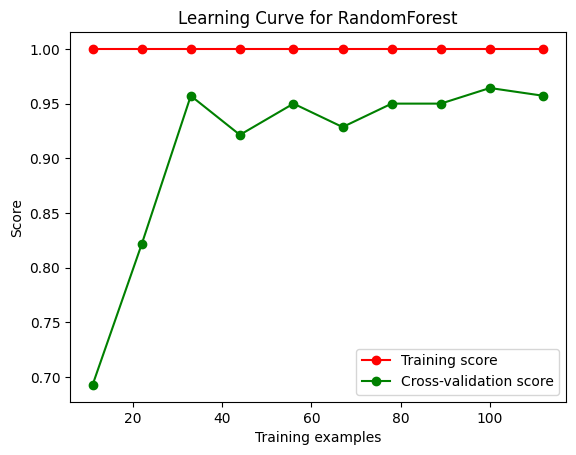

In [228]:
#Shreeya 
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    train_features, train_labels, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curve for RandomForest')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


In [231]:
# Random Forest Evaluation Unseen features - Ashley Hunt - psyah10

unseen_feature_prediction = rfc_model.predict(UNSEEN_FEATURES)
print("Prediction on unseen data:", decode_labels(unseen_feature_prediction))

#actual_unseen_data = ['circle', 'circle', 'come', 'come', 'go', 'go', 'wave', 'wave']
print("Actual unseen data:", actual_unseen_data)
unseen_results = [a == b for a, b in zip(actual_unseen_data, decode_labels(unseen_feature_prediction))]
print("Accuracy:", unseen_results.count(True) / len(unseen_results))

Prediction on unseen data: ['come' 'circle' 'wave' 'go' 'come' 'go' 'circle' 'wave']
Actual unseen data: ['circle', 'circle', 'come', 'come', 'go', 'go', 'wave', 'wave']
Accuracy: 0.375


In [214]:
# Support Vector Machines - Ashley Hunt - psyah10
from sklearn import svm

svm_model = svm.SVC(kernel='linear') # Linear Kernel

svm_model.fit(train_features, train_labels)

SVC(kernel='linear')

In [215]:
svm_y_pred = svm_model.predict(test_features)

print(f"Accuracy: {accuracy_score(test_labels, svm_y_pred)}")
print(classification_report(test_labels, svm_y_pred))

unseen_feature_prediction = svm_model.predict(UNSEEN_FEATURES)
print("Prediction on unseen data:", decode_labels(unseen_feature_prediction))

unseen_results = [a == b for a, b in zip(actual_unseen_data, decode_labels(unseen_feature_prediction))]
print("Accuracy:", unseen_results.count(True) / len(unseen_results))

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.95      1.00      0.98        20
           2       1.00      0.87      0.93        15
           3       0.93      1.00      0.97        14

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Prediction on unseen data: ['come' 'circle' 'wave' 'wave' 'come' 'come' 'circle' 'wave']
Accuracy: 0.25


In [ ]:
# Ashley Hunt - psyah10
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

DO_MODEL_TUNING = False

if(DO_MODEL_TUNING):
      rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
      rf_random.fit(train_features, train_labels)
      
      rf_random.best_params_

In [ ]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#     return accuracy

# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(features, encoded_labels)
# base_accuracy = evaluate(base_model, test_features, test_labels)

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, test_features, test_labels)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# Amit Kumar
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# for train_index, test_index in sss.split(features, encoded_labels):
#     train_features, test_features = features[train_index], features[test_index]
#     train_labels, test_labels = encoded_labels[train_index], encoded_labels[test_index]
#     print(f"  Test:  index={test_index}")
#     print(f"  Train: index={train_index}")
    
# rfc = RandomForestClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
 
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
# grid_search.fit(train_features, train_labels)

# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)

In [ ]:
# Amit Kumar
# from xgboost import XGBClassifier
 
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
 
# for train_index, test_index in sss.split(X, y):
#     train_features, test_features = X[train_index], X[test_index]
#     train_labels, test_labels = y[train_index], y[test_index]
    
# xgb_classifier = XGBClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }
 
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
# grid_search.fit(train_features, train_labels)
 
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
 
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)